This dashboard provides an interactive platform for the user to explore public health data retrieved from the UK Health Security Agency (UKHSA) API, in particular, exploring measles cases in England in from October 2023 up until today (November 2024). The user has the ability to refresh the data as the UK Health Security Agency keeps adding new information about the cases each week. For this, we will be using the source: https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/vaccine_preventable/topics/Measles/geography_types/Nation/geographies/England/metrics/measles_cases_casesByOnsetWeek"

We start off by importing all the libraries and modules we will need to analyse and create the graphs that we want. 
As a brief summary; 
pandas provides the data structure, in our case, the DataFrame, that allows us to handle time-series data. 
numpy is used for numerical computations.
matplotlib.pyplot will allow us to create static and interactive visualisations.
matplotlib.dates will allow us to format our time-series data.
requests will allow us to interact with the UKHSA API.
time will allow us to carry out time relates tasks.
json will be used to read and write a json file, which is where we will store the UKHSA measles data.


In [1]:
from IPython.display import clear_output 
import ipywidgets as wdg 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests 
import time
import json

requests.get("https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/vaccine_preventable/topics/Measles/geography_types/Nation/geographies/England/metrics/measles_cases_casesByOnsetWeek").json();


We proceed to define the class that will pull out the data from the UKHSA API. The data will be divided up in pages, allowing for our dataset to be divided into smaller groups. Definition: Pagination is a technique used to split large datasets into smaller groups, or "pages," to make it easier to retrieve, process, and display data. The below class would allow for the return of each 'next page' and to loop over pages and get it in one go.

In [2]:
class APIwrapper:
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0

    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric): #no need to change this line
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        self.count=None
        
        
    def get_page(self, filters={}, page_size=5):
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        if self._next_url==None: 
            return []
        curr_time=time.time()
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33:
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        response = requests.get(self._next_url, params=parameters).json()
        self._next_url=response['next']
        self.count=response['count']
        return response['results'] 


    def get_all_pages(self, filters={}, page_size=365):
        data=[] 
        while True:
            next_page=self.get_page(filters, page_size)
            if next_page==[]:
                break 
            data.extend(next_page)
        return data

Next, we define a structure dictionary that contains the parameters of our queries, as well as a filters dictionary to filter our results. This will be particularly important for our dataset as it is divided by age ranges, so by filtering it to 'all' we will get England's Measles cases for all ages. We then proceed to download all data for our weekly measles cases and we call .get_all_pages() to get all the pages at once;

In [3]:
structure={"theme": "infectious_disease", 
           "sub_theme": "vaccine_preventable",
           "topic": "Measles",
           "geography_type": "Nation", 
           "geography": "England",
          "metric":"measles_cases_casesByOnsetWeek"}

filters={"stratum" : None, 
         "age": 'all', 
         "sex": 'all', 
         "year": None, 
         "month": None,
         "epiweek" :None, 
         "date" : None, 
         "in_reporting_delay_period": None 
        }
structure["metric"]="measles_cases_casesByOnsetWeek"
api=APIwrapper(**structure)
measles_cases=api.get_all_pages(filters)

We then proceed to create a json file and save our data in it;

In [4]:
with open("measles_cases.json", "wt") as OUTF: 
    json.dump(measles_cases, OUTF)

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

with open("measles_cases.json", "rt") as INFILE:
    measles_cases=json.load(INFILE)
  

Once the data is saved, we proceed to retrieve the values and put them in a dictionary, with the dates acting as keys. We also sort the dates.

In [5]:
data={}
for dataset in [measles_cases]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][metric]=value


dates=list(data.keys())
dates.sort()

We then convert the date string into a pandas datetime object. And now for the important bit, creating our DataFrame. Our index will be the data range below defined, and our column will be measles cases.

In [6]:
def parse_date(datestring):
    return pd.to_datetime(datestring, format="%Y-%m-%d")

startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])

index=pd.date_range(startdate, enddate, freq='D')
timeseriesdf=pd.DataFrame(index=index, columns=['measles_cases'])

We then proceed to fill out our Dataframe with values from our statistics, measles cases.

In [7]:
index=pd.date_range(startdate, enddate, freq='D')
timeseriesdf=pd.DataFrame(index=index, columns=['measles_cases'])


metrics ={'measles_cases': 'measles_cases_casesByOnsetWeek'}

for date, entry in data.items(): 
    pd_date=parse_date(date)
    for column in ['measles_cases']: 
        metric_name=metrics[column]
        value= entry.get(metric_name, 0.0)
        timeseriesdf.loc[date, column]=value
            

Finally, before we plot the data, we group our dataset by quarters, reducing the amount of data.

/tmp/ipykernel_1644/561487907.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = timeseriesdf.groupby(pd.Grouper(freq='Q')).mean()


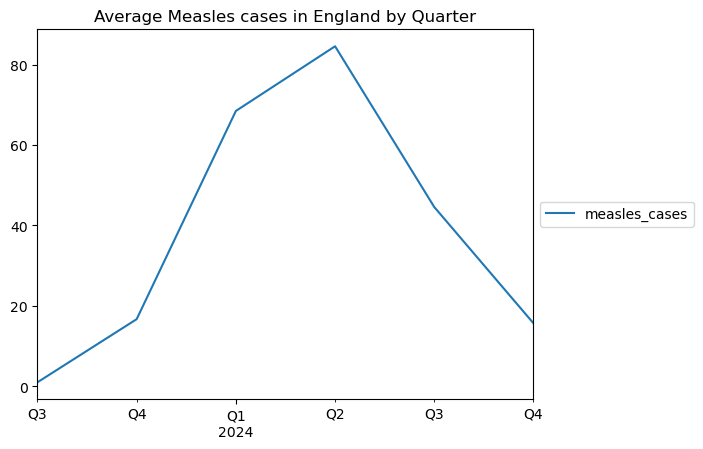

In [8]:
quarterly = timeseriesdf.groupby(pd.Grouper(freq='Q')).mean()
quarterly = quarterly[::-1]  
ax=quarterly.plot()
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax.set_title('Average Measles cases in England by Quarter');


We then define our API access function that will allow the user to refresh the data;

In [9]:
def access_api(button):
    apibutton.icon="check"
    apibutton.disabled=True

  
apibutton=wdg.Button( 
    description='Refresh data',
    disabled=False,
    button_style='info', 
    tooltip='Click to download current Public Health England data',
    icon='download' 
)


apibutton.on_click(access_api)


display(apibutton)

Button(button_style='info', description='Refresh data', icon='download', style=ButtonStyle(), tooltip='Click t…

And finally, we create an interactive button for the user to have the ability to either select data from 2023 or 2024. This way, the user can have a more granular view, and the user can appreciate the 'peak' of cases early 2024, and the downwards trend throughout 2024. Even though this particular graph does not separate between age groups, as we filtered to show all of the age groups and the country together, the data could allow a programmer to analyse the data per age groups, and per regions, appreciating the peaks in the Midlands, driven by a large outbreak in Birmingham in late 2023.

In [10]:
year = wdg.Dropdown(
    options=sorted(timeseriesdf.index.year.unique()), 
    value=timeseriesdf.index.year[-1], 
    description='Year:',
    disabled=False
)

def year_graph(graphyear):
    yeardf = timeseriesdf[timeseriesdf.index.year == graphyear]
    monthly = yeardf.groupby(pd.Grouper(freq='1M')).mean()
    ax = monthly.plot(kind='bar', cmap='tab20')     
    ax.set_xticklabels(monthly.index.strftime('%Y-%m-%d'), rotation=45)
    ax.set_title(f"Monthly Data for {graphyear}")
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')

    plt.tight_layout()  
    plt.show()


output = wdg.interactive_output(year_graph, {'graphyear': year})


display(year, output)

Dropdown(description='Year:', index=1, options=(2023, 2024), value=2024)

Output()